# Introduction to Verde

Unlike xESMF, verde is mainly designed around unstructured grids. Verde has a lot of great examples, we will use an atmospheric one below, but highly reccomend reading though the documents to get a better handle on the API.

https://www.fatiando.org/verde/latest/

### Prerequisites

Knowing your way around pandas, xarray, numpy and matplotlib is beneficial. This is not deisgned to be an introduction to any of those packages. We will be using Cartopy for some of the plots as well. 

# Imports

In [166]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf

from appdirs import *

import verde as vd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [167]:
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
cartopy   : 0.18.0
numpy     : 1.21.5
verde     : 1.7.0
pandas    : 1.4.3
matplotlib: 3.5.2



In [168]:
colnames=['remove', 'lon', 'lat', 'date', 'sensor', 'PM25value', 'sensor_type'] 

df = pd.read_csv('airnow_data.csv', names=colnames, header=None)
df = df.drop(columns='remove')
df.head(3)

,lon,lat,date,sensor,PM25value,sensor_type
0,41.783083,-110.537888,2022-09-05T16:00,PM2.5,45,1
1,40.294300,-110.009000,2022-09-05T16:00,PM2.5,40,1
2,40.464722,-109.560830,2022-09-05T16:00,PM2.5,30,1


In [169]:
df.date = pd.to_datetime(df.date)
df.dtypes

lon                   float64
lat                   float64
date           datetime64[ns]
sensor                 object
PM25value               int64
sensor_type             int64
dtype: object

Let's pick a time that has decent coverage:

In [170]:
df.date.value_counts().head()

2022-09-05 16:00:00    36
2022-09-06 07:00:00    36
2022-09-06 20:00:00    36
2022-09-06 19:00:00    36
2022-09-06 18:00:00    36
Name: date, dtype: int64

In [171]:
df2 = df[df.date == '2022-09-06T07:00']
df2.head(3)

,lon,lat,date,sensor,PM25value,sensor_type
540,41.783083,-110.537888,2022-09-06 07:00:00,PM2.5,16,1
541,40.294300,-110.009000,2022-09-06 07:00:00,PM2.5,29,1
542,40.464722,-109.560830,2022-09-06 07:00:00,PM2.5,23,1


## Plotting the data

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


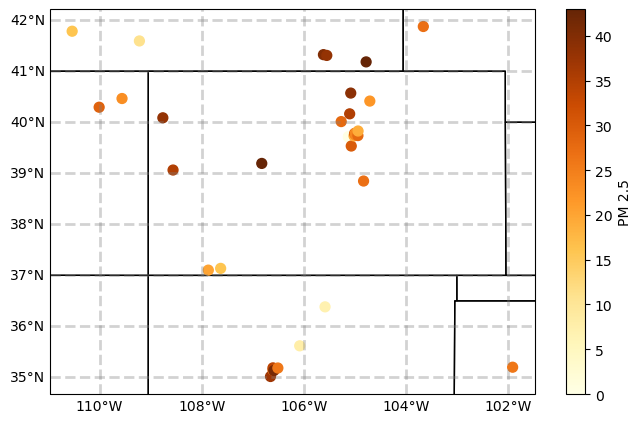

In [172]:
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.35, linestyle='--')

gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-110, -108,  -106, -104, -102])

plt.scatter(df2.lat, 
            df2.lon, 
            c = df2.PM25value,
            s=50,
            cmap="YlOrBr")

plt.colorbar().set_label("PM 2.5")
plt.show()

# Verde Workflows

Some of these workflows might not work super well, this is just to show the mechanics of the package. 

In [173]:
coordinates = (df2.lon, df2.lat)

### Trend Estimation

Same code, different example can be found here: https://www.fatiando.org/verde/latest/tutorials/trends.html

In [174]:
trend = vd.Trend(degree=1).fit(coordinates, df2.PM25value)
print(trend.coef_)

[38.39163129  0.54379964  0.32281663]


In [175]:
trend_values = trend.predict(coordinates)
residuals = df2.PM25value - trend_values

/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


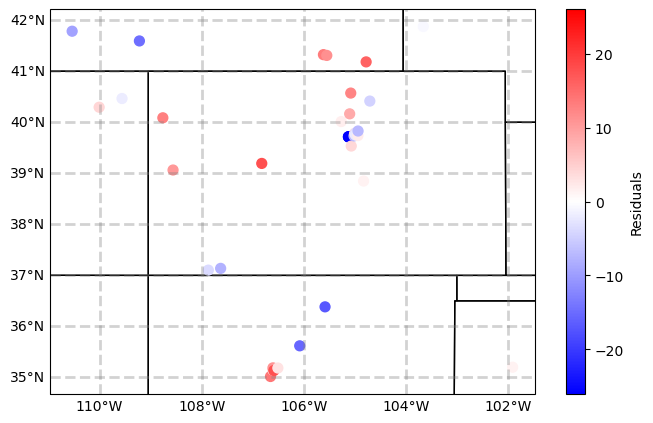

In [176]:
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.35, linestyle='--')

gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-110, -108,  -106, -104, -102])

maxabs = vd.maxabs(residuals)


plt.scatter(df2.lat, 
            df2.lon, 
            c = residuals,
            s=50,
            vmin=-maxabs,
            vmax=maxabs,
            cmap="bwr")

plt.colorbar().set_label("Residuals")
plt.show()

Unlike the Texas example in Verde, hard to see a distince trend. 

### Data Decimation

In [200]:
spacing = 30 / 60

reducer = vd.BlockReduce(reduction=np.median, spacing= spacing)
print(reducer)

BlockReduce(reduction=<function median at 0x104f95670>, spacing=0.5)


In [201]:
filter_coords, filter_data = reducer.filter(
    coordinates=(df2.lat, df2.lon), data=df2.PM25value
)

In [202]:
np.shape(filter_coords)[1]

21

In [203]:
np.shape(data)

(21,)

In [204]:
np.shape(df2.lon)

(36,)

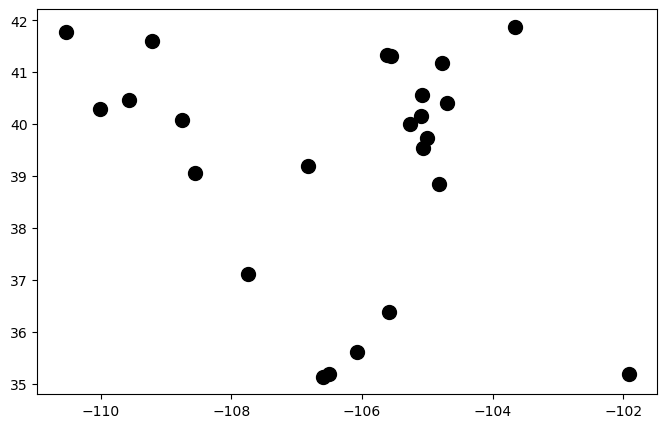

In [205]:
plt.figure(figsize=(8, 5))

plt.plot(*filter_coord, ".k",  markersize=20)

plt.show()

### Verde Spline

In [277]:
spline = vd.Spline().fit(filter_coords, filter_data)

In [278]:
grid = spline.grid(spacing=spacing , data_names="PM25")
print("Cartesian grid:")
print(grid)

Cartesian grid:
<xarray.Dataset>
Dimensions:   (northing: 14, easting: 18)
Coordinates:
  * easting   (easting) float64 -110.5 -110.0 -109.5 ... -102.9 -102.4 -101.9
  * northing  (northing) float64 35.14 35.66 36.18 36.7 ... 40.84 41.36 41.88
Data variables:
    PM25      (northing, easting) float64 74.69 69.09 63.62 ... 11.73 6.292
Attributes:
    metadata:  Generated by Spline()


/Users/tmartin/opt/anaconda3/envs/ml_scratch/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


In [283]:
distance_mask = 1
grid = vd.distance_mask(filter_coords, maxdist=distance_mask, grid=grid)

In [293]:
q = str(distance_mask)

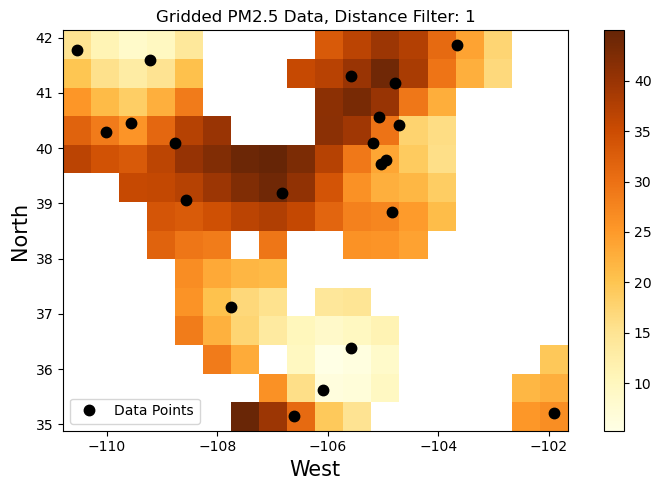

In [302]:
plt.figure(figsize=(8, 5))

pc = grid.PM25.plot.pcolormesh(cmap="YlOrBr", add_colorbar=False)
plt.colorbar(pc)
plt.plot(filter_coords[0], filter_coords[1], ".k", markersize=15, label='Data Points')

plt.title('Gridded PM2.5 Data, Distance Filter: '+str(distance_mask))

plt.xlabel("West", size=15)
plt.ylabel("North", size=15)
plt.legend()
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

In [261]:
grid.PM25.to_dataset()

<xarray.Dataset>
Dimensions:   (easting: 18, northing: 14)
Coordinates:
  * easting   (easting) float64 -110.5 -110.0 -109.5 ... -102.9 -102.4 -101.9
  * northing  (northing) float64 35.14 35.66 36.18 36.7 ... 40.84 41.36 41.88
Data variables:
    PM25      (northing, easting) float64 nan nan nan nan ... 17.54 nan nan